In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import io
import matplotlib.pyplot as plt
from skimage.data import imread   # or, whatever image library you prefer
import csv
import tensorflow as tf

# Define the data paths
tfrecords_filename = '../input/train-100k.tfrecords'
category_data=pd.read_csv("../input/category_names.csv")

In [2]:
print("Total categories are:", len(category_data))

def concat_category_names(row):
    return "|".join([row['category_level1'],row['category_level2'],row['category_level3']])

category_data['category_name'] = category_data.apply(concat_category_names, axis=1)

category_names_df = category_data[['category_id', 'category_name']]
category_names_dict = category_names_df.set_index('category_id').T.to_dict('list')
category_names_dict[1000021794]

Total categories are: 5270


['ABONNEMENT / SERVICES|CARTE PREPAYEE|CARTE PREPAYEE MULTIMEDIA']

In [27]:
train_labels= []

opts = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.ZLIB)
record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename, options=opts)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    label = int(example.features.feature['category_id']
                                 .int64_list
                                 .value[0])
    train_labels.append(label)

In [37]:
len(set(train_labels))

3779

In [47]:
l_counts = [(x, train_labels.count(x)) for x in set(train_labels)]

In [57]:
sorted_counts = sorted(l_counts, key=lambda tup:(-tup[1], tup[0]))
sorted_counts
list1, list2 = zip(*sorted_counts)

In [66]:
list1_str = list(map(str, list1))
y_pos = np.arange(len(list1_str))

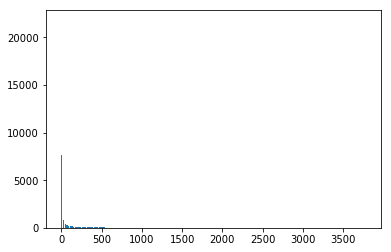

In [67]:
plt.bar(y_pos, list2)
plt.show()

In [3]:
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

def read_and_decode(filename_queue):
    
    opts = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.ZLIB)
    reader = tf.TFRecordReader(options=opts)

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'category_id': tf.FixedLenFeature([], tf.int64),
        'product_id': tf.FixedLenFeature([], tf.int64),
        'img_raw': tf.FixedLenFeature([], tf.string),
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image_raw = tf.decode_raw(features['img_raw'], tf.uint8)    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    label = tf.cast(features['category_id'], tf.int32)
    
    image_shape = tf.stack([IMAGE_HEIGHT, IMAGE_WIDTH, 3])    
    image = tf.reshape(image_raw, image_shape)
    
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, -1), dtype=tf.int32)
    #we could add preprocessing here.
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    images, labels = tf.train.shuffle_batch( [resized_image, label],
                                                 batch_size=10,
                                                 capacity=30,
                                                #seed=1,
                                                 num_threads=2,
                                                 min_after_dequeue=10)
    return images, labels

['INFORMATIQUE|PROTECTION - PERSONNALISATION - SUPPORT|COQUE - HOUSSE']
['INFORMATIQUE|CONNECTIQUE - ALIMENTATION|CHARGEUR - ADAPTATEUR SECTEUR - ALLUME CIGARE - SOLAIRE']
['MUSIQUE|CD|CD MUSIQUE DU MONDE']
['TELEPHONIE - GPS|ACCESSOIRE TELEPHONE|HOUSSE - ETUI - CHAUSSETTE']
['BAGAGERIE|MAROQUINERIE|SAC A MAIN']
['TELEPHONIE - GPS|ACCESSOIRE TELEPHONE|CHARGEUR TELEPHONE - ADAPTATEUR ALIMENTATION TELEPHONE']
['LIBRAIRIE|SCIENCES HUMAINES|SOCIOLOGIE']
['TELEPHONIE - GPS|ACCESSOIRE TELEPHONE|COQUE TELEPHONE - BUMPER TELEPHONE']
['TELEPHONIE - GPS|ACCESSOIRE TELEPHONE|COQUE TELEPHONE - BUMPER TELEPHONE']
['INFORMATIQUE|CONNECTIQUE - ALIMENTATION|CHARGEUR - ADAPTATEUR SECTEUR - ALLUME CIGARE - SOLAIRE']


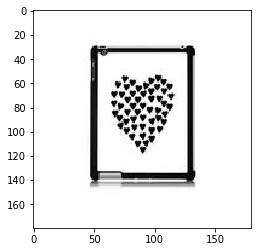

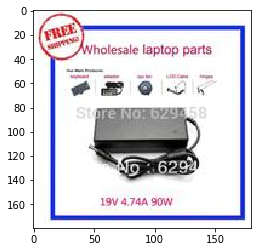

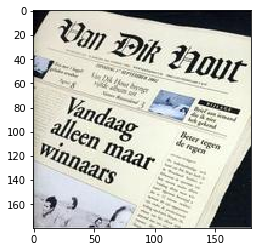

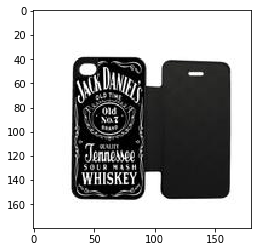

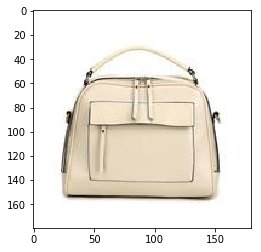

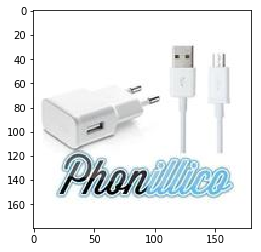

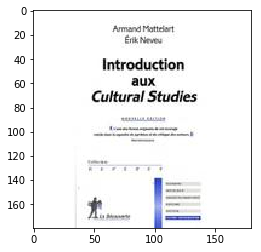

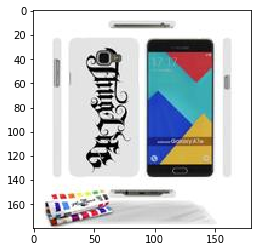

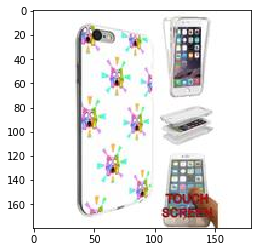

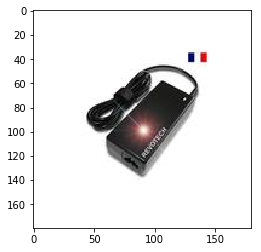

In [12]:
filename_queue = tf.train.string_input_producer([tfrecords_filename])

img_batch, label_batch = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    sess.run(init_op)

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    # Let's read off 3 batches just for example
    for i in range(10):
        imgs, labels = sess.run([img_batch, label_batch])
        print(category_names_dict[labels[0]])
        plt.figure()
        plt.imshow(imgs[0, :, :, :])
    
    coord.request_stop()
    coord.join(threads)